In [2]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
import gym

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [4]:
# master class that performs environment interaction and learning
class Master():
    def __init__(self,
                 env,
                 n_actor,
                 n_critic,
                 n_place,
                 dt,
                 V_0,
                 tau_r,
                 stepSize=1,
                 actor_lr=0.05,
                 critic_lr=0.2):
        
        # gym
        self.env = env
        if type(env.action_space) == gym.spaces.discrete.Discrete:
            self.action_dim = env.action_space.n
            self.discrete_actions = True
        else:
            self.action_dim = env.action_space.shape[0]
            self.discrete_actions = False
            
        self.state_dim = env.observation_space.shape[0]
        self.stepsize = stepSize
        self.dt = dt
        self.state = env.reset()
        self.reward = 0
        self.done = False
        self.reward_history = []
        self.totalReward = 0

        self.V_0 = V_0
        self.tau_r = tau_r
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.place_actor_weights = 2*np.random.randn(n_actor, n_place)/n_actor
        self.place_critic_weights = 2*np.random.randn(n_critic, n_place)/n_critic
#         self.place_actor_weights = np.random.uniform(n_actor, n_place)
#         self.place_critic_weights = np.random.uniform(n_critic, n_place)
#         self.td_error_history = []
    
    def sensor(self, t):
        return self.state
    
    def get_reward(self, t):
        return self.reward
    
    def step(self,t,x):
        if int(t / self.dt) % self.stepsize != 0:
            return
        
        if self.discrete_actions:
            action = np.random.choice(self.action_dim, p=softmax(x))
#             action = np.argmax(x)
        else:
            action = x
#         self.env.render()
#         print(f'STEP... x: {x}, action: {action}')
        self.state, self.reward, self.done, _ = self.env.step(action)
        self.totalReward += self.reward
        if self.done:
#             print('done')
            self.reward = -2
            self.totalReward += self.reward
            self.reward_history.append(self.totalReward)
            self.state = self.env.reset()
            self.totalReward = 0

#     def calc_td_error(self, t, x):
#         td_error = np.sum(x) - self.V_0/self.tau_r + self.reward
#         print('td_error:', td_error, np.sum(x), self.reward)
#         self.td_error_history.append(td_error)
#         return td_error

    def outer(self, t, x):
        X_j_conv_eps = x[:n_place]
        Y = x[n_place:]
        return np.outer(Y, X_j_conv_eps).flatten()
    
    def actor(self, t, x):
        dVdw = x[:n_place * n_actor].reshape(n_actor, n_place)
        place_spikes = x[n_place * n_actor:-1]
        td_error = x[-1]#self.td_error_history[-1]
#         print(f'ACTOR... mean(dVdw): {np.mean(dVdw)}, sum(dVdw){np.sum(dVdw)}, td: {td_error}')
        self.place_actor_weights += self.actor_lr * td_error * dVdw

        return np.dot(self.place_actor_weights, place_spikes)
        
    def critic(self, t, x):
        dVdw = x[:n_place * n_critic].reshape(n_critic, n_place)
        place_spikes = x[n_place * n_critic:-1]
        td_error = x[-1]#self.td_error_history[-1]
#         print(f'CRITIC... mean(dVdw): {np.mean(dVdw)}, sum(dVdw){np.sum(dVdw)}, td: {td_error}')
        self.place_critic_weights += self.critic_lr * td_error * dVdw

        return np.dot(self.place_critic_weights, place_spikes)

V_0 = 0
tau_r = 1 # reward time constant
v_k = 50e-3
tau_k = 200e-3
eps_0 = 20e-3
tau_m = 20e-3
tau_s = 5e-3
dt = 1e-3
n_actor = 100
n_critic = 100
n_place = 100
place_radius = 10
actor_radius = 2
critic_radius = 10
stepSize = 5
actor_lr = 0.05
critic_lr = 0.2

env = gym.make('CartPole-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Acrobot-v1')
master = Master(
    env=env,
    n_actor=n_actor,
    n_critic=n_critic,
    n_place=n_place,
    dt=dt,
    V_0=V_0,
    tau_r=tau_r,
    stepSize=stepSize,
    actor_lr=actor_lr,
    critic_lr=critic_lr
)
model = nengo.Network()

with model:
    state_node = nengo.Node(output=master.sensor)
    reward_node = nengo.Node(output=master.get_reward)
    place = nengo.Ensemble(n_neurons=n_place,
                           dimensions=master.state_dim,
                           radius=place_radius)
    nengo.Connection(state_node, place)
    
    
    actor = nengo.Ensemble(n_neurons=n_actor,
                           dimensions=master.action_dim,
                           radius=actor_radius)
    actor_learn_conn = nengo.Connection(place,
                                        actor,
                                        function=lambda x:[0]*master.action_dim,
                                        learning_rule_type=nengo.PES(actor_lr))
    
    step_node = nengo.Node(output=master.step, size_in=master.action_dim)
    nengo.Connection(actor, step_node)
    
    critic = nengo.Ensemble(n_neurons=n_critic,
                            dimensions=1,
                            radius=critic_radius)
    critic_learn_conn = nengo.Connection(place,
                                         critic,
                                         function=lambda x:0,
                                         learning_rule_type=nengo.PES(critic_lr))
    
    nengo.Connection(reward_node,
                     critic_learn_conn.learning_rule,
                     synapse=0.02,
                     transform=1)
    nengo.Connection(critic,
                     critic_learn_conn.learning_rule,
                     synapse=0.02,
                     transform=-1)
    nengo.Connection(reward_node, 
                     actor_learn_conn.learning_rule,
                     function=lambda x:[0]*master.action_dim,
                     synapse=0.02,
                     transform=1)
    nengo.Connection(critic, 
                     actor_learn_conn.learning_rule,
                     function=lambda x:[0]*master.action_dim,
                     synapse=0.02,
                     transform=-1)
    
#     err_probe = nengo.Probe(td_error_node, synapse=None)
    actor_probe = nengo.Probe(actor, synapse=None)
    critic_probe = nengo.Probe(critic, synapse=None)
    place_probe = nengo.Probe(place, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(20)

master.env.close()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

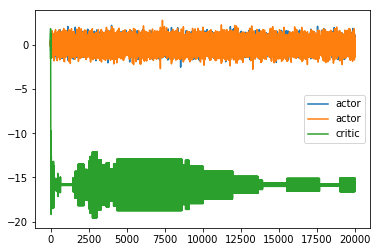

In [7]:
# plt.plot(sim.data[err_probe], label='td_error')
plt.plot(sim.data[actor_probe], label='actor')
plt.plot(sim.data[critic_probe], label='critic')
# plt.plot(sim.data[place_probe], label='place')
plt.legend()

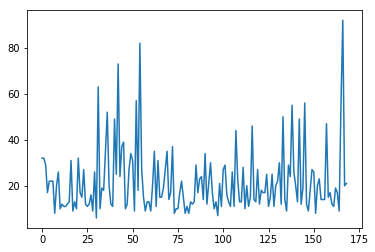

In [8]:
plt.plot(master.reward_history)

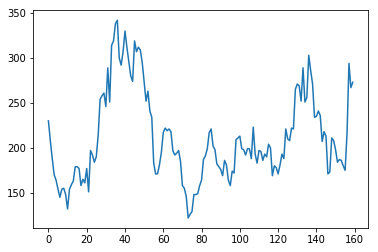

In [9]:
plt.plot(np.convolve(master.reward_history, np.ones(10), 'valid'))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

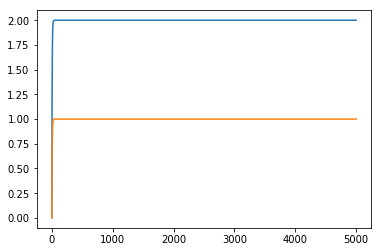

In [168]:
xs = []
def yolo(t, x):
    xs.append(x)

# l = lambda t: 1 if t % 0.1 == 0 else 0
# l = lambda t: 1 if t % 0.002 == 0 else -1
l = lambda t: 2

    
model = nengo.Network()
with model:
    nd_input1 = nengo.Node(2 ,size_out=1)
    nd_input2 = nengo.Node(1 ,size_out=1)
    td_error_node = nengo.Node(output=None, size_in=2)
    nengo.Connection(nd_input1, td_error_node[:-1])
    nengo.Connection(nd_input2, td_error_node[-1])
#     nengo.Connection(critic.neurons, td_error_node, synapse=None)
    # convolve critic spikes with (K' - K/tau_r)
#     nengo.Connection(nd_input,
#                      td_error_node,
#                      synapse=tau_k,
#                      transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
#     nengo.Connection(nd_input,
#                      td_error_node,
#                      synapse=v_k,
#                      transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))
    p = nengo.Probe(td_error_node)
    
    
with nengo.Simulator(model) as sim:
    sim.run(5)
    
plt.plot(sim.data[p])


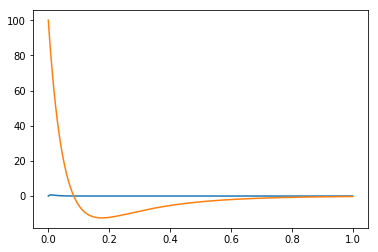

In [55]:
def k(t, v_k=50e-3, tau_k=200e-3):
    return ( np.exp(-t/tau_k) - np.exp(-t/v_k)) / (tau_k-v_k)
ts = np.arange(0,1,1e-3)
# plt.plot(ts, k(ts))

def k_dot(t, v_k=50e-3, tau_k=200e-3):
    return ( -np.exp(-t/tau_k)/tau_k + np.exp(-t/v_k)/v_k) / (tau_k-v_k)
# plt.plot(ts, k_dot(ts))

def epsp(s, eps_zero=20e-3, tau_m=20e-3, tau_s=5e-3):
    return (eps_zero/(tau_m - tau_s))*(np.exp(-s/tau_m)-np.exp(-s/tau_s))*np.heaviside(s, 1)
plt.plot(ts, epsp(ts))

plt.plot(ts, k_dot(ts) - k(ts)/1)


In [9]:
# master class that performs environment interaction and learning
class Master():

    def __init__(self,
                 env,
                 n_actor,
                 n_critic,
                 n_place,
                 dt,
                 V_0,
                 tau_r,
                 stepSize=1,
                 actor_lr=0.05,
                 critic_lr=0.2):

        # gym
        self.env = env
        if type(env.action_space) == gym.spaces.discrete.Discrete:
            self.action_dim = env.action_space.n
            self.discrete_actions = True
        else:
            self.action_dim = env.action_space.shape[0]
            self.discrete_actions = False

        self.state_dim = env.observation_space.shape[0]
        self.stepsize = stepSize
        self.dt = dt
        self.state = env.reset()
        self.reward = 0
        self.done = False
        self.reward_history = []
        self.totalReward = 0

        self.V_0 = V_0
        self.tau_r = tau_r
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.place_actor_weights = 2 * np.random.randn(n_actor,
                                                       n_place) / n_actor
        self.place_critic_weights = 2 * np.random.randn(n_critic,
                                                        n_place) / n_critic
#         self.place_actor_weights = np.random.uniform(n_actor, n_place)
#         self.place_critic_weights = np.random.uniform(n_critic, n_place)
#         self.td_error_history = []

    def step(self, t, x):
        if int(t / self.dt) % self.stepsize != 0:
            return

        if self.discrete_actions:
#             action = np.argmax(x)
            action = np.random.choice(self.action_dim, p=softmax(x))
        else:
            action = x
#         self.env.render()
#         print(f'STEP... x: {x}, action: {action}')
        self.state, self.reward, self.done, _ = self.env.step(action)
        self.totalReward += self.reward
        if self.done:
            #             print('done')
            self.reward = -2
            self.totalReward += self.reward
            self.reward_history.append(self.totalReward)
            self.state = self.env.reset()
            self.totalReward = 0


#     def calc_td_error(self, t, x):
#         td_error = np.sum(x) - self.V_0/self.tau_r + self.reward
#         print('td_error:', td_error, np.sum(x), self.reward)
#         self.td_error_history.append(td_error)
#         return td_error

    def outer(self, t, x):
        X_j_conv_eps = x[:n_place]
        Y = x[n_place:]
        return np.outer(Y, X_j_conv_eps).flatten()

    def actor(self, t, x):
        dVdw = x[:n_place * n_actor].reshape(n_actor, n_place)
        place_spikes = x[n_place * n_actor:-1]
        td_error = x[-1]  #self.td_error_history[-1]
        #         print(f'ACTOR... mean(dVdw): {np.mean(dVdw)}, sum(dVdw){np.sum(dVdw)}, td: {td_error}')
        self.place_actor_weights += self.actor_lr * td_error * dVdw

        return np.dot(self.place_actor_weights, place_spikes)

    def critic(self, t, x):
        dVdw = x[:n_place * n_critic].reshape(n_critic, n_place)
        place_spikes = x[n_place * n_critic:-1]
        td_error = x[-1]  #self.td_error_history[-1]
        #         print(f'CRITIC... mean(dVdw): {np.mean(dVdw)}, sum(dVdw){np.sum(dVdw)}, td: {td_error}')
        self.place_critic_weights += self.critic_lr * td_error * dVdw

        return np.dot(self.place_critic_weights, place_spikes)

V_0 = 0
tau_r = 1  # reward time constant
v_k = 50e-3
tau_k = 200e-3
eps_0 = 20e-3
tau_m = 20e-3
tau_s = 5e-3
dt = 1e-3
n_actor = 100
n_critic = 100
n_place = 100
place_radius = 10
actor_radius = 2
critic_radius = 10
stepSize = 10
actor_lr = 0.05
critic_lr = 0.2

env = gym.make('CartPole-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Acrobot-v1')
master = Master(
    env=env,
    n_actor=n_actor,
    n_critic=n_critic,
    n_place=n_place,
    dt=dt,
    V_0=V_0,
    tau_r=tau_r,
    stepSize=stepSize,
    actor_lr=actor_lr,
    critic_lr=critic_lr)
model = nengo.Network()

with model:
    state_node = nengo.Node(output=master.state)
    reward_node = nengo.Node(output=master.reward)
    place = nengo.Ensemble(
        n_neurons=n_place, dimensions=master.state_dim, radius=place_radius)
    nengo.Connection(state_node, place)

    #####################################################

    actor = nengo.Ensemble(
        n_neurons=n_actor, dimensions=master.action_dim, radius=actor_radius)

    actor_outer = nengo.Node(
        master.outer, size_in=n_place + n_actor, size_out=n_place * n_actor)
    # convolve place spikes with epsilon
    nengo.Connection(
        place.neurons,
        actor_outer[:n_place],
        synapse=tau_m,
        transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(
        place.neurons,
        actor_outer[:n_place],
        synapse=tau_s,
        transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw actor spikes into actor_outer
    nengo.Connection(actor.neurons, actor_outer[n_place:], synapse=None)

    actor_learn = nengo.Node(
        master.actor, size_in=n_place * n_actor + n_place + 1, size_out=n_actor)
    # convolve actor_outer output with k / tau_r
    nengo.Connection(
        actor_outer,
        actor_learn[:n_place * n_actor],
        synapse=tau_k,
        transform=tau_k / ((tau_k - v_k) * tau_r))
    nengo.Connection(
        actor_outer,
        actor_learn[:n_place * n_actor],
        synapse=v_k,
        transform=(-v_k) / ((tau_k - v_k) * tau_r))
    # Pass raw place spikes into actor_learn
    nengo.Connection(
        place.neurons, actor_learn[n_place * n_actor:-1], synapse=None)

    # connect actor_learn to actor neurons
    nengo.Connection(actor_learn, actor.neurons, synapse=None)

    step_node = nengo.Node(output=master.step, size_in=master.action_dim)
    nengo.Connection(actor, step_node)

    #####################################################

    critic = nengo.Ensemble(
        n_neurons=n_critic, dimensions=1, radius=critic_radius)
    critic_outer = nengo.Node(
        master.outer, size_in=n_place + n_critic, size_out=n_place * n_critic)
    # convolve place spikes with epsilon
    nengo.Connection(
        place.neurons,
        critic_outer[:n_place],
        synapse=tau_m,
        transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(
        place.neurons,
        critic_outer[:n_place],
        synapse=tau_s,
        transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw critic spikes into critic_outer
    nengo.Connection(critic.neurons, critic_outer[n_place:], synapse=None)

    critic_learn = nengo.Node(
        master.critic,
        size_in=n_place * n_critic + n_place + 1,
        size_out=n_critic)
    # convolve critic_outer output with k / tau_r
    nengo.Connection(
        critic_outer,
        critic_learn[:n_place * n_critic],
        synapse=tau_k,
        transform=tau_k / ((tau_k - v_k) * tau_r))
    nengo.Connection(
        critic_outer,
        critic_learn[:n_place * n_critic],
        synapse=v_k,
        transform=(-v_k) / ((tau_k - v_k) * tau_r))
    # Pass raw place spikes into critic_learn
    nengo.Connection(
        place.neurons, critic_learn[n_place * n_critic:-1], synapse=None)

    # connect critic_learn to critic neurons
    nengo.Connection(critic_learn, critic.neurons, synapse=None)

    #####################################################

    td_error_node = nengo.Node(output=None, size_in=1)
    nengo.Connection(reward_node, td_error_node)
    # convolve critic spikes with (K' - K/tau_r)
    nengo.Connection(
        critic.neurons,
        td_error_node,
        synapse=tau_k,
        transform=((-tau_r - tau_k) / (tau_r * (tau_k - v_k))))
    nengo.Connection(
        critic.neurons,
        td_error_node,
        synapse=v_k,
        transform=((tau_r + v_k) / (tau_r * (tau_k - v_k))))
    # pass td_error to learn nodes
    nengo.Connection(td_error_node, actor_learn[-1], synapse=None)
    nengo.Connection(td_error_node, critic_learn[-1], synapse=None)

    err_probe = nengo.Probe(td_error_node, synapse=None)
    actor_probe = nengo.Probe(actor, synapse=None)
    critic_probe = nengo.Probe(critic, synapse=None)
    place_probe = nengo.Probe(place, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(10)

master.env.close()

ValidationError: init: Shape of initial value () does not match expected shape (1, 100)